<h1>Predictive Maintenance Using LSTM and GRU on NASA Turbofan Engine Dataset</h1>

<h1>Data Preprocessing</h1>

In [231]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

# Load the data
train_data = pd.read_csv('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/CMAPPSS/train_FD001.txt', sep=' ', header=None)
test_data = pd.read_csv('C:/Users/gouta/OneDrive - andrew.cmu.edu\Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/CMAPPSS/test_FD001.txt', sep=' ', header=None)
rul_data = pd.read_csv('C:/Users/gouta/OneDrive - andrew.cmu.edu\Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/CMAPPSS/RUL_FD001.txt', delim_whitespace=True, header=None) 


column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
               [f'sensor_measurement_{i}' for i in range(1, 24)]  # There are 21 sensor columns
train_data.columns = column_names
test_data.columns = column_names

# Drop columns that are mostly NaN (sensor_measurement_22, sensor_measurement_23)
train_data = train_data.drop(columns=['sensor_measurement_22', 'sensor_measurement_23'], errors='ignore')
test_data = test_data.drop(columns=['sensor_measurement_22', 'sensor_measurement_23'], errors='ignore')

#Missing values check
missing_values_train = train_data.isnull().sum()
missing_values_test = test_data.isnull().sum()

# print("Missing values in train data:\n", missing_values_train)
# print("Missing values in test data:\n", missing_values_test)

#######
# TRAIN
#######
#maximum cycle value for each engine (id) and storing it in a new DataFrame (rul)
rul = train_data.groupby('unit_number')['time_in_cycles'].max().reset_index()

# Rename the columns in the rul DataFrame
rul.columns = ['unit_number', 'max_cycle']

# Merge the rul DataFrame with the original train_df based on the 'unit_number' column
train_df = train_data.merge(rul, on=['unit_number'], how='left')

# Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']

# Remove the temporary column used to calculate RUL
train_df= train_df.drop(['max_cycle'],axis=1)



# Generate label columns for training data
# We will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15

# Create a binary label ('label1') indicating if the engine will fail within w1 cycles (1) or not (0)
train_df['label1'] = train_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
# Initialize a second label ('label2') as a copy of 'label1'
train_df['label2'] = train_df['label1']
# Update 'label2' to indicate if the engine will fail within w0 cycles (2) or not (0/1)
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
# Create a normalized version of the 'time_in_cycles' column (e.g., 'cycle_norm') using the original 'cycle' values
train_df['cycle_norm'] = train_df['time_in_cycles'] / train_df.groupby('unit_number')['time_in_cycles'].transform('max')

# Select the columns to be normalized (all columns except 'unit_number', 'time_in_cycles', 'RUL', 'label1', and 'label2')
cols_normalize = train_df.columns.difference(['unit_number', 'time_in_cycles', 'RUL', 'label1', 'label2'])

# Initialize a MinMaxScaler object to scale values between 0 and 1
min_max_scaler = MinMaxScaler()

# Apply MinMaxScaler to the selected columns and create a new normalized DataFrame
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_data.index)

# Remove 'cycle_norm' from norm_train_df to avoid column overlap during the join
if 'cycle_norm' in norm_train_df.columns:
    norm_train_df = norm_train_df.drop(columns=['cycle_norm'])

# Join the normalized DataFrame with the original DataFrame (excluding normalized columns)
join_df = train_df[['unit_number', 'time_in_cycles', 'RUL', 'label1', 'label2', 'cycle_norm']].join(norm_train_df)

# Reorder the columns in the joined DataFrame to match the original order
train_df = join_df.reindex(columns=train_data.columns.tolist() + ['RUL', 'label1', 'label2', 'cycle_norm'])

# Print statement to reference whether an engine will fail within w1 cycles
# for index, row in train_df.iterrows():
#     if row['label1'] == 1:
#         print(f"Engine {row['unit_number']} is likely to fail within {w1} cycles (Remaining cycles: {row['RUL']})")
#     else:
#         print(f"Engine {row['unit_number']} is NOT likely to fail within {w1} cycles (Remaining cycles: {row['RUL']})")

In [133]:
######
# TEST
######

# MinMax normalization (from 0 to 1)
test_data['cycle_norm'] = test_data['time_in_cycles'] / test_data.groupby('unit_number')['time_in_cycles'].transform('max')

norm_test_df = pd.DataFrame(min_max_scaler.transform(test_data[cols_normalize]), columns=cols_normalize, index=test_data.index)

# Remove 'cycle_norm' from norm_test_df to avoid column overlap during the join
if 'cycle_norm' in norm_test_df.columns:
    norm_test_df = norm_test_df.drop(columns=['cycle_norm'])

test_join_df = test_data[['unit_number', 'time_in_cycles', 'cycle_norm']].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_data.columns.tolist() + ['cycle_norm'])

# We use the ground truth dataset to generate labels for the test data.
rul = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul.columns = ['unit_number', 'max']

truth_df = pd.DataFrame(rul_data)
truth_df.columns = ['more']
truth_df['unit_number'] = truth_df.index + 1
# If the rul DataFrame has the correct column names
rul = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul.columns = ['unit_number', 'max']

truth_df['max'] = rul['max'] + truth_df['more']

# Merge the adjusted truth_df with the test_df to generate RUL values for test data
test_df = test_df.merge(truth_df[['unit_number', 'max']], on='unit_number', how='left')
test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']
test_df.drop(['max'], axis=1, inplace=True)

# Generate binary label columns (label1 and label2) based on RUL values and thresholds w0 and w1
test_df['label1'] = test_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [135]:
display(train_data)

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


<h2>Feature Engineering</h2>

In [137]:
# 1. Feature Engineering: Moving Averages
# Create moving averages for the sensor measurements over a 3-cycle window
window_size = 3
for col in train_data:
    train_data[f'{col}_moving_avg'] = train_data.groupby('unit_number')[col].rolling(window=window_size).mean().reset_index(drop=True)
    test_data[f'{col}_moving_avg'] = test_data.groupby('unit_number')[col].rolling(window=window_size).mean().reset_index(drop=True)

# Print output of moving averages
print("Train data with moving averages (first few rows):")
print(train_data[[col for col in train_data.columns if '_moving_avg' in col]].head())

Train data with moving averages (first few rows):
   unit_number_moving_avg  time_in_cycles_moving_avg  \
0                     NaN                        NaN   
1                     NaN                        NaN   
2                     1.0                        2.0   
3                     1.0                        3.0   
4                     1.0                        4.0   

   operational_setting_1_moving_avg  operational_setting_2_moving_avg  \
0                               NaN                               NaN   
1                               NaN                               NaN   
2                         -0.001033                         -0.000133   
3                         -0.000567                          0.000000   
4                         -0.001833                          0.000033   

   operational_setting_3_moving_avg  sensor_measurement_1_moving_avg  \
0                               NaN                              NaN   
1                             

In [139]:
# 2. Feature Engineering: Trend Features (differences between consecutive sensor readings)
for col in train_data:
    train_data[f'{col}_trend'] = train_data.groupby('unit_number')[col].diff().fillna(0)
    test_data[f'{col}_trend'] = test_data.groupby('unit_number')[col].diff().fillna(0)

# Print output of trend features
print("Train data with trend features (first few rows):")
print(train_data[[col for col in train_data.columns if '_trend' in col]].head())

Train data with trend features (first few rows):
   unit_number_trend  time_in_cycles_trend  operational_setting_1_trend  \
0                0.0                   0.0                       0.0000   
1                0.0                   1.0                       0.0026   
2                0.0                   1.0                      -0.0062   
3                0.0                   1.0                       0.0050   
4                0.0                   1.0                      -0.0026   

   operational_setting_2_trend  operational_setting_3_trend  \
0                       0.0000                          0.0   
1                       0.0001                          0.0   
2                       0.0006                          0.0   
3                      -0.0003                          0.0   
4                      -0.0002                          0.0   

   sensor_measurement_1_trend  sensor_measurement_2_trend  \
0                         0.0                        0.00   

In [141]:
# 3. Feature Engineering: Aggregating Sensor Data (mean, std, min, max)
# Aggregating the sensor data to get overall statistics
sensor_columns = [col for col in train_data.columns if 'sensor_measurement_' in col]
for stat in ['mean', 'std', 'min', 'max']:
    train_data[f'sensor_{stat}'] = train_data[sensor_columns].agg(stat, axis=1)
    test_data[f'sensor_{stat}'] = test_data[sensor_columns].agg(stat, axis=1)

# Print output of aggregated features
print("Train data with aggregated features (mean, std, min, max):")
print(train_data[['sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']].head())

Train data with aggregated features (mean, std, min, max):
   sensor_mean   sensor_std  sensor_min  sensor_max
0   479.740135  1589.264297        0.00     9046.19
1   479.605433  1588.595625       -7.13     9044.07
2   719.701753  1897.015034       -3.83     9052.94
3   719.391864  1896.864804       -5.20     9049.48
4   719.817908  1897.294922       -2.99     9055.15


In [237]:
# Check for NaN values in the selected columns
# nan_columns = train_data[sensor_columns].columns[train_data[sensor_columns].isna().any()].tolist()
#print("Columns with NaN values:", nan_columns)

In [145]:
# Fill NaN values with column means
train_data[sensor_columns] = train_data[sensor_columns].fillna(train_data[sensor_columns].mean())
test_data[sensor_columns] = test_data[sensor_columns].fillna(train_data[sensor_columns].mean())

In [147]:
# Define the columns to include in PCA
cols_to_scale = [col for col in train_data.columns if 'sensor_measurement_' in col]

# Include aggregated features if desired
cols_to_scale += ['sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']

# Standardize the data
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data[cols_to_scale])
scaled_test = scaler.transform(test_data[cols_to_scale])

# Apply PCA
pca = PCA(n_components=10)
pca_train = pca.fit_transform(scaled_train)
pca_test = pca.transform(scaled_test)

# Print explained variance
print("Variance by PCA components:")
print(pca.explained_variance_ratio_)

# Print PCA transformed data
print("PCA transformed train data (first few rows):")
print(pd.DataFrame(pca_train).head())

# Optionally, integrate PCA components into the original DataFrames
pca_columns = [f'PCA_{i+1}' for i in range(pca_train.shape[1])]
pca_train_df = pd.DataFrame(pca_train, columns=pca_columns)
pca_test_df = pd.DataFrame(pca_test, columns=pca_columns)

# Reset index
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
pca_train_df.reset_index(drop=True, inplace=True)
pca_test_df.reset_index(drop=True, inplace=True)

# Concatenate PCA components with original data
train_data = pd.concat([train_data, pca_train_df], axis=1)
test_data = pd.concat([test_data, pca_test_df], axis=1)

# # Drop original sensor columns if desired
# train_data.drop(columns=cols_to_scale, inplace=True)
# test_data.drop(columns=cols_to_scale, inplace=True)


Variance by PCA components:
[0.30933057 0.08422036 0.03742228 0.03389254 0.03103714 0.02812782
 0.02774808 0.02730521 0.027201   0.02638721]
PCA transformed train data (first few rows):
          0         1         2         3          4         5         6  \
0 -2.404924 -1.811627  0.885273  5.739619  12.810050  1.415879 -0.008673   
1 -2.041804 -2.348246  0.834267  4.649861  12.715112  1.837476 -0.058290   
2 -4.314034 -0.613612 -0.232299  0.851899  -0.309465 -1.387872  0.781847   
3 -4.799786 -1.281553 -0.322925 -0.644284   0.102723  1.303710  1.401369   
4 -3.956855 -0.156404 -0.357565  0.639194  -0.294851  0.378687  0.042406   

          7         8         9  
0  1.517400 -0.673449 -1.422508  
1  1.733864 -1.051155 -2.423022  
2  0.444107 -0.095363  0.596204  
3  0.521661 -0.669637  1.256821  
4 -0.824880 -2.271733  0.864605  


<h1>Model Building</h1>

<h2>LSTM</h2>

In [149]:
#  window size and sequence length
sequence_length = 50 

# Function to reshape features into (samples, time steps, features)
def generate_sequences(id_df, sequence_length, feature_columns):
    data_matrix = id_df[feature_columns].values
    num_elements = data_matrix.shape[0]

    # Generate sequences
    for start in range(num_elements):
        end = start + sequence_length
        if end <= num_elements:
            # Full sequence
            seq = data_matrix[start:end, :]
            yield seq
        else:
            # Pad sequences shorter than sequence_length with zeros
            seq = data_matrix[start:num_elements, :]
            padding = np.zeros((sequence_length - seq.shape[0], data_matrix.shape[1]))
            seq = np.vstack((seq, padding))
            yield seq

# feature columns for sequence generation (e.g., sensor readings, settings)
sensor_columns = [col for col in train_df.columns if 'sensor_measurement_' in col]

# Including operational settings
sequence_columns = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + sensor_columns

# Sequences for all engine ids in the training data
sequence_list = []
for id in train_df['unit_number'].unique():
    id_df = train_df[train_df['unit_number'] == id]
    sequences = list(generate_sequences(id_df, sequence_length, sequence_columns))
    sequence_list.extend(sequences)

# TODO: Convert generated sequences to a numpy array for LSTM input
sequence_array = np.array(sequence_list)
print("Sequence array shape:", sequence_array.shape)

# TODO: Function to generate labels
def generate_labels(id_df, sequence_length, label_column):
    """Generate labels for a given id."""
    data_array = id_df[label_column].values
    num_elements = data_array.shape[0]
    labels = []
    for start in range(num_elements):
        end = start + sequence_length
        if end <= num_elements:
            # Use the label at the end of the sequence
            label = data_array[end - 1]
        else:
            # For sequences shorter than sequence_length, use the last available label
            label = data_array[-1]
        labels.append(label)
    return labels

# TODO: Generate labels for all engine ids in the training data
label_list = []
for id in train_df['unit_number'].unique():
    id_df = train_df[train_df['unit_number'] == id]
    labels = generate_labels(id_df, sequence_length, 'label1')
    label_list.extend(labels)

# TODO: Convert labels to a numpy array
label_array = np.array(label_list)
label_array = label_array.reshape(-1, 1)
print("Label array shape:", label_array.shape)

Sequence array shape: (20631, 50, 24)
Label array shape: (20631, 1)


In [151]:
# Define the number of features and output units
nb_features = sequence_array.shape[2]
nb_out = label_array.shape[1]

# Calculate the number of parameters to ensure it's under 10,000
units_1 = 16
units_2 = 8

params_LSTM1 = 4 * units_1 * (units_1 + nb_features + 1)
params_LSTM2 = 4 * units_2 * (units_2 + units_1 + 1)
params_Dense = units_2 * nb_out + nb_out
total_params = params_LSTM1 + params_LSTM2 + params_Dense

print("Total parameters in LSTM model:", total_params)

# Check if total_params is less than 10,000
if total_params > 10000:
    raise ValueError("Total parameters exceed 10,000. Adjust the number of units.")

# Create a Sequential model
model = Sequential()

# First LSTM layer
model.add(LSTM(
    units=units_1,
    return_sequences=True,
    input_shape=(sequence_length, nb_features)
))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(
    units=units_2,
    return_sequences=False
))
model.add(Dropout(0.2))

# Add a Dense output layer with sigmoid activation
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Total parameters in LSTM model: 3433


C:\Users\gouta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 16)         │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,433 (13.41 KB)

 Trainable params: 3,433 (13.41 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
lstm = model.fit(
    sequence_array,
    label_array,
    epochs=50,            
    batch_size=200,       
    validation_split=0.1, # Use 10% of data for validation
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6457 - loss: 0.5937
Epoch 1: val_loss improved from inf to 0.29087, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6471 - loss: 0.5927 - val_accuracy: 0.9317 - val_loss: 0.2909
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9367 - loss: 0.2669
Epoch 2: val_loss improved from 0.29087 to 0.17999, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9368 - loss: 0.2665 - val_accuracy: 0.9351 - val_loss: 0.1800
Epoch 3/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9538 - loss: 0.1625
Epoch 3: val_loss improved from 0.17999 to 0.13952, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9538 - loss: 0.1623 - val_accuracy: 0.9433 - val_loss: 0.1395
Epoch 4/50
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9589 - loss: 0.1287
Epoch 4: val_loss improved from 0.13952 to 0.10973, saving m

In [155]:
lstm_2 = model.fit(
    sequence_array,
    label_array,
    epochs=30,            
    batch_size=200,       
    validation_split=0.1, # Use 10% of data for validation
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.005,
            patience=10,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9776 - loss: 0.0545
Epoch 1: val_loss improved from inf to 0.05386, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9776 - loss: 0.0545 - val_accuracy: 0.9734 - val_loss: 0.0539
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9778 - loss: 0.0558
Epoch 2: val_loss improved from 0.05386 to 0.04200, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9778 - loss: 0.0558 - val_accuracy: 0.9806 - val_loss: 0.0420
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9782 - loss: 0.0549
Epoch 3: val_loss did not improve from 0.04200
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9782 - loss: 0.0549 - val_accuracy: 0.9772 - val_loss: 0.0501
Epoch 4/30
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9774 - loss: 0.0558
Epoch 4: val_loss did not improve from 0.04200
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 

<h3>Testing of different hyper parameters, with change in epochs from 50 to 30, min_delta from 0.0001 to 0.005 and patience from 5 to 10 yielding to 98.19% accuracy from 97.7%</h3>

<h3>GRU</h3>

In [158]:
grumodel = Sequential()
grumodel.add(GRU(
    units=20,
    return_sequences=True,
    input_shape=(sequence_length, nb_features)
))
grumodel.add(Dropout(0.2))
grumodel.add(GRU(
    units=10,
    return_sequences=False
))
grumodel.add(Dropout(0.2))
grumodel.add(Dense(units=nb_out, activation='sigmoid'))
# Compile the model with binary crossentropy loss and Adam optimizer
grumodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
grumodel.summary()

C:\Users\gouta\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 50, 20)         │         2,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,731 (14.57 KB)

 Trainable params: 3,731 (14.57 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
gru = grumodel.fit(
    sequence_array,
    label_array,
    epochs=50,            
    batch_size=200,       
    validation_split=0.1, # Use 10% of data for validation
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_gru_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8166 - loss: 0.4859
Epoch 1: val_loss improved from inf to 0.15186, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.8173 - loss: 0.4843 - val_accuracy: 0.9438 - val_loss: 0.1519
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9542 - loss: 0.1289
Epoch 2: val_loss improved from 0.15186 to 0.13671, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9542 - loss: 0.1289 - val_accuracy: 0.9448 - val_loss: 0.1367
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9564 - loss: 0.1146
Epoch 3: val_loss did not improve from 0.13671
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9564 - loss: 0.1146 - val_accuracy: 0.9385 - val_loss: 0.1447
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9608 - loss: 0.1044
Epoch 4: val_loss improved from 0.13671 to 0.09827, saving model to best_gru_model.keras
9

In [162]:
gru_2 = grumodel.fit(
    sequence_array,
    label_array,
    epochs=20,            
    batch_size=200,       
    validation_split=0.1, # Use 10% of data for validation
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=10,
            verbose=1,
            mode='min'
        ),
        ModelCheckpoint(
            filepath='best_gru_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        )
    ]
)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9827 - loss: 0.0450
Epoch 1: val_loss improved from inf to 0.06082, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9827 - loss: 0.0450 - val_accuracy: 0.9714 - val_loss: 0.0608
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9800 - loss: 0.0475
Epoch 2: val_loss did not improve from 0.06082
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9800 - loss: 0.0475 - val_accuracy: 0.9700 - val_loss: 0.0622
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9812 - loss: 0.0471
Epoch 3: val_loss improved from 0.06082 to 0.04220, saving model to best_gru_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9812 - loss: 0.0471 - val_accuracy: 0.9811 - val_loss: 0.0422
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9826 - loss: 0.0433
Epoch 4: val_loss improved from 0.04220 to 0.03965, saving model to best_gru_model.keras
93

<h3>With change in hyper parameters of Epoch, patience and min_delta. The accuracy improved from 98.3% to 98.5%.</h3>

<h2>Advanced Feature Engineering</h2>

<h3>Rolling Features</h3>

In [223]:
def create_rolling_features(df, sensor_cols, window_size):
    df = df.copy()
    # Empty DataFrames to store rolling statistics
    rolling_means = pd.DataFrame(index=df.index)
    rolling_stds = pd.DataFrame(index=df.index)
    
    for col in sensor_cols:
        if not isinstance(col, str):
            raise ValueError(f"Expected column name as string, got {type(col)}")
        
        # Calculate rolling mean per unit_number
        rolling_mean = (
            df.groupby('unit_number')[col]
            .rolling(window=window_size, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
        # Assigning to rolling_means DataFrame
        rolling_means[f"{col}_rolling_mean"] = rolling_mean
        
        # Calculate rolling std per unit_number
        rolling_std = (
            df.groupby('unit_number')[col]
            .rolling(window=window_size, min_periods=1)
            .std()
            .reset_index(level=0, drop=True)
        )
        rolling_stds[f"{col}_rolling_std"] = rolling_std
    
    # Concatenate the rolling statistics with the original DataFrame
    df = pd.concat([df, rolling_means, rolling_stds], axis=1)
    
    return df


window_size = 10 

# Get the list of sensor columns without rolling statistics columns
sensor_columns = [
    col for col in train_data.columns
    if 'sensor_measurement' in col and '_rolling_' not in col
]

train_data = create_rolling_features(train_data, sensor_columns, window_size)

# Check the new columns added to the DataFrame
#print("Columns in train_data after adding rolling features:")
#print(train_data.columns.tolist())


<h3>Rolling statistics for sensor measurement-7 and unit 5</h3>

C:\Users\gouta\AppData\Local\Temp\ipykernel_25136\3867939387.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[f"{sensor_to_plot}_rolling_mean"].fillna(plot_data[f"{sensor_to_plot}_rolling_mean"].mean(), inplace=True)
C:\Users\gouta\AppData\Local\Temp\ipykernel_25136\3867939387.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[f"{sensor_to_plot}_rolling_std"].fillna(plot_data[f"{sensor_to_plot}_rolling_std"].mean(), inplace=True)


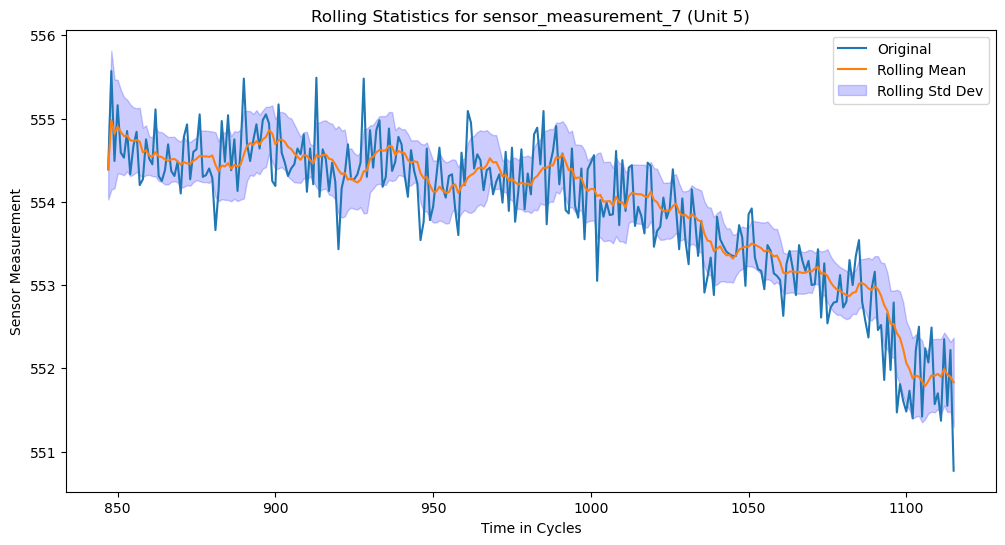

In [211]:
import matplotlib.pyplot as plt

unit_to_inspect = 5
sensor_to_plot = "sensor_measurement_7"

# Ensure plot_data is filtered correctly
plot_data = train_data[train_data['unit_number'] == unit_to_inspect]

# Check if rolling mean and std exist, and calculate them if necessary
if f"{sensor_to_plot}_rolling_mean" not in plot_data.columns:
    plot_data[f"{sensor_to_plot}_rolling_mean"] = plot_data[sensor_to_plot].rolling(window=10).mean()
if f"{sensor_to_plot}_rolling_std" not in plot_data.columns:
    plot_data[f"{sensor_to_plot}_rolling_std"] = plot_data[sensor_to_plot].rolling(window=10).std()

# Fill NaN values with the mean of the column
plot_data[f"{sensor_to_plot}_rolling_mean"].fillna(plot_data[f"{sensor_to_plot}_rolling_mean"].mean(), inplace=True)
plot_data[f"{sensor_to_plot}_rolling_std"].fillna(plot_data[f"{sensor_to_plot}_rolling_std"].mean(), inplace=True)

# Calculate y1 and y2 for sensor_measurement_7
y1 = plot_data[f"{sensor_to_plot}_rolling_mean"] - plot_data[f"{sensor_to_plot}_rolling_std"]
y2 = plot_data[f"{sensor_to_plot}_rolling_mean"] + plot_data[f"{sensor_to_plot}_rolling_std"]

# Reset index if necessary (just for safety)
if isinstance(plot_data.index, pd.MultiIndex):
    plot_data = plot_data.reset_index(drop=True)
    y1.index = plot_data.index
    y2.index = plot_data.index

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data[sensor_to_plot], label='Original')
plt.plot(plot_data.index, plot_data[f"{sensor_to_plot}_rolling_mean"], label='Rolling Mean')
plt.fill_between(plot_data.index, y1, y2, color='b', alpha=0.2, label='Rolling Std Dev')

plt.title(f"Rolling Statistics for {sensor_to_plot} (Unit {unit_to_inspect})")
plt.xlabel('Time in Cycles')
plt.ylabel('Sensor Measurement')
plt.legend()
plt.savefig('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/rolling_features_U5_SM7.png')
plt.show()

<h3>Rolling statistics for sensor measurement 4 and unit-3</h3>

C:\Users\gouta\AppData\Local\Temp\ipykernel_25136\1680159039.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[f"{sensor_to_plot}_rolling_mean"].fillna(plot_data[f"{sensor_to_plot}_rolling_mean"].mean(), inplace=True)
C:\Users\gouta\AppData\Local\Temp\ipykernel_25136\1680159039.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[f"{sensor_to_plot}_rolling_std"].fillna(plot_data[f"{sensor_to_plot}_rolling_std"].mean(), inplace=True)


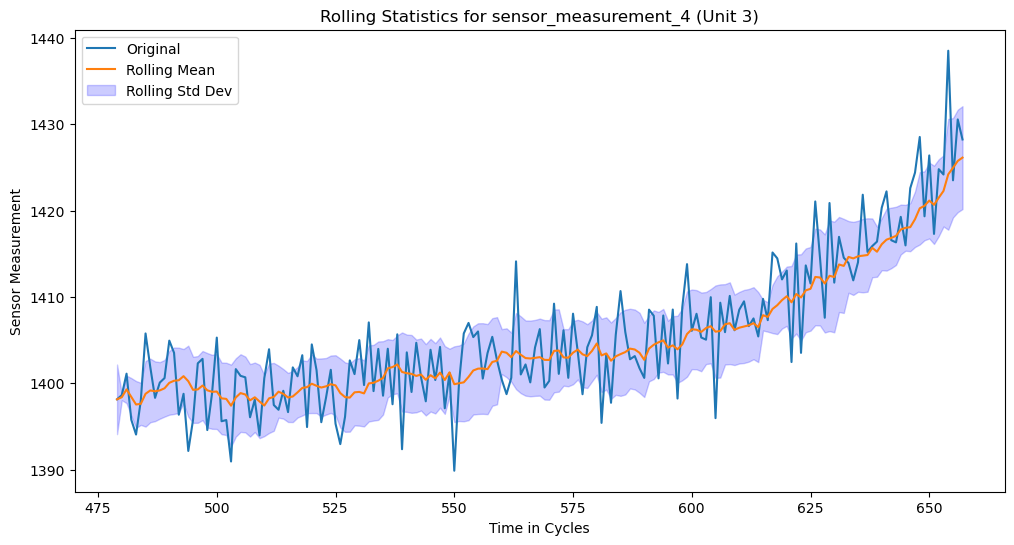

In [213]:
unit_to_inspect = 3
sensor_to_plot = "sensor_measurement_4"

# Ensure plot_data is filtered correctly
plot_data = train_data[train_data['unit_number'] == unit_to_inspect]

# Check if rolling mean and std exist, and calculate them if necessary
if f"{sensor_to_plot}_rolling_mean" not in plot_data.columns:
    plot_data[f"{sensor_to_plot}_rolling_mean"] = plot_data[sensor_to_plot].rolling(window=10).mean()
if f"{sensor_to_plot}_rolling_std" not in plot_data.columns:
    plot_data[f"{sensor_to_plot}_rolling_std"] = plot_data[sensor_to_plot].rolling(window=10).std()

# Fill NaN values with the mean of the column
plot_data[f"{sensor_to_plot}_rolling_mean"].fillna(plot_data[f"{sensor_to_plot}_rolling_mean"].mean(), inplace=True)
plot_data[f"{sensor_to_plot}_rolling_std"].fillna(plot_data[f"{sensor_to_plot}_rolling_std"].mean(), inplace=True)

# Calculate y1 and y2 for sensor_measurement_7
y1 = plot_data[f"{sensor_to_plot}_rolling_mean"] - plot_data[f"{sensor_to_plot}_rolling_std"]
y2 = plot_data[f"{sensor_to_plot}_rolling_mean"] + plot_data[f"{sensor_to_plot}_rolling_std"]

# Reset index if necessary (just for safety)
if isinstance(plot_data.index, pd.MultiIndex):
    plot_data = plot_data.reset_index(drop=True)
    y1.index = plot_data.index
    y2.index = plot_data.index

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data[sensor_to_plot], label='Original')
plt.plot(plot_data.index, plot_data[f"{sensor_to_plot}_rolling_mean"], label='Rolling Mean')
plt.fill_between(plot_data.index, y1, y2, color='b', alpha=0.2, label='Rolling Std Dev')

plt.title(f"Rolling Statistics for {sensor_to_plot} (Unit {unit_to_inspect})")
plt.xlabel('Time in Cycles')
plt.ylabel('Sensor Measurement')
plt.legend()
plt.savefig('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/rolling_features_U3_SM4.png')
plt.show()

<h3>Time-Based Features</h3>

In [225]:
# Time-based features since the engine starts and the remaining time since the last maintenance for training data
train_data['time_since_start'] = train_data.groupby('unit_number').cumcount()
train_data['time_remaining'] = train_data.groupby('unit_number')['time_since_start'].transform('max') - train_data['time_since_start']

# print("Time since the engine started (training data): \n " , train_data['time_since_start'].head(20))
# print("\n\n")
# print("Time remaining since the last maintenance (training data): \n " , train_data['time_remaining'].head(20))

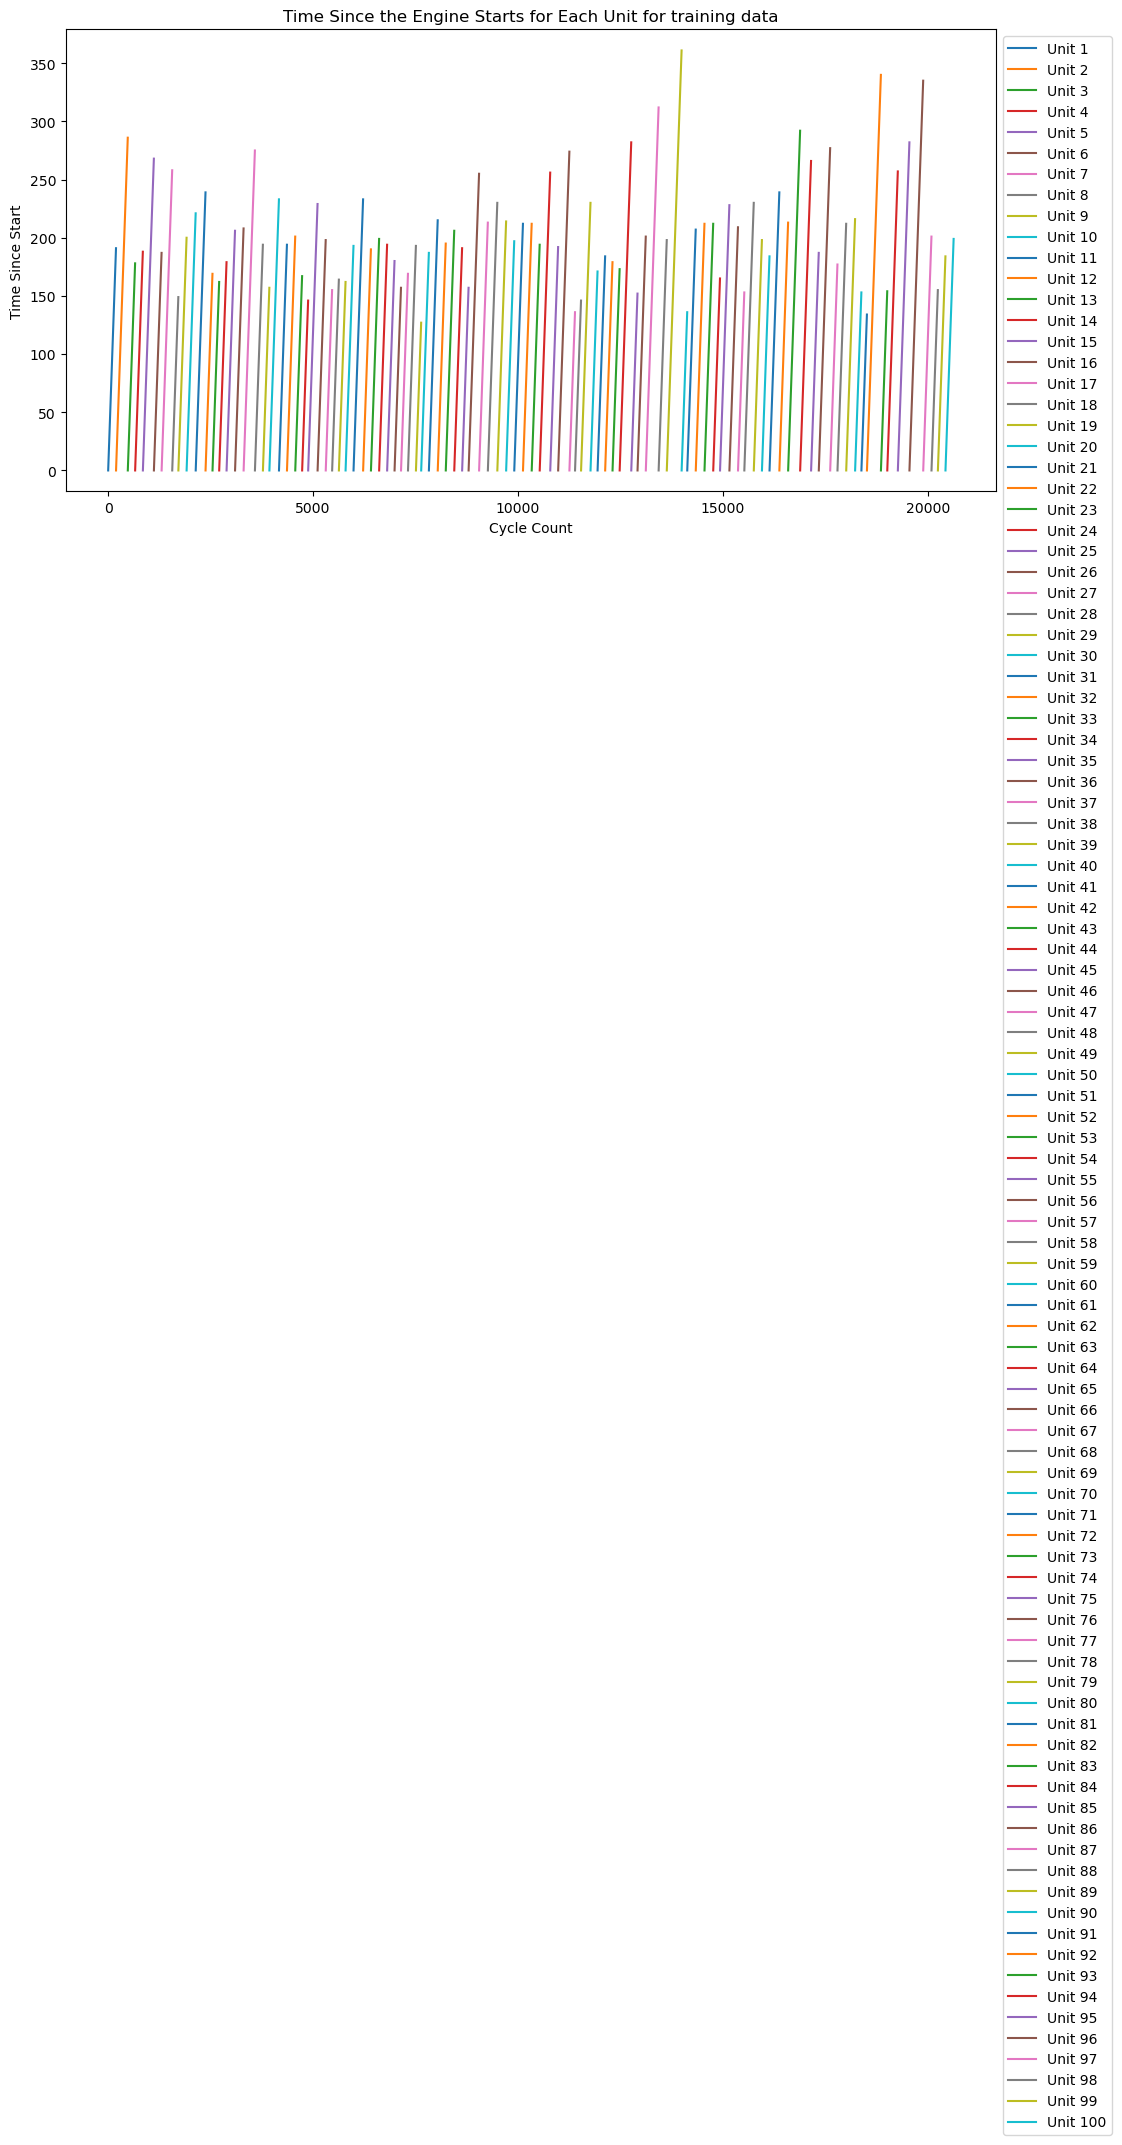

In [219]:
# Plot 'time_since_start for training data'
plt.figure(figsize=(12, 6))
for unit in train_data['unit_number'].unique():
    unit_data = train_data[train_data['unit_number'] == unit]
    plt.plot(unit_data['time_since_start'], label=f'Unit {unit}')
plt.title('Time Since the Engine Starts for Each Unit for training data')
plt.xlabel('Cycle Count')
plt.ylabel('Time Since Start')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/timebased_features_units_eng_start.png')
plt.show()

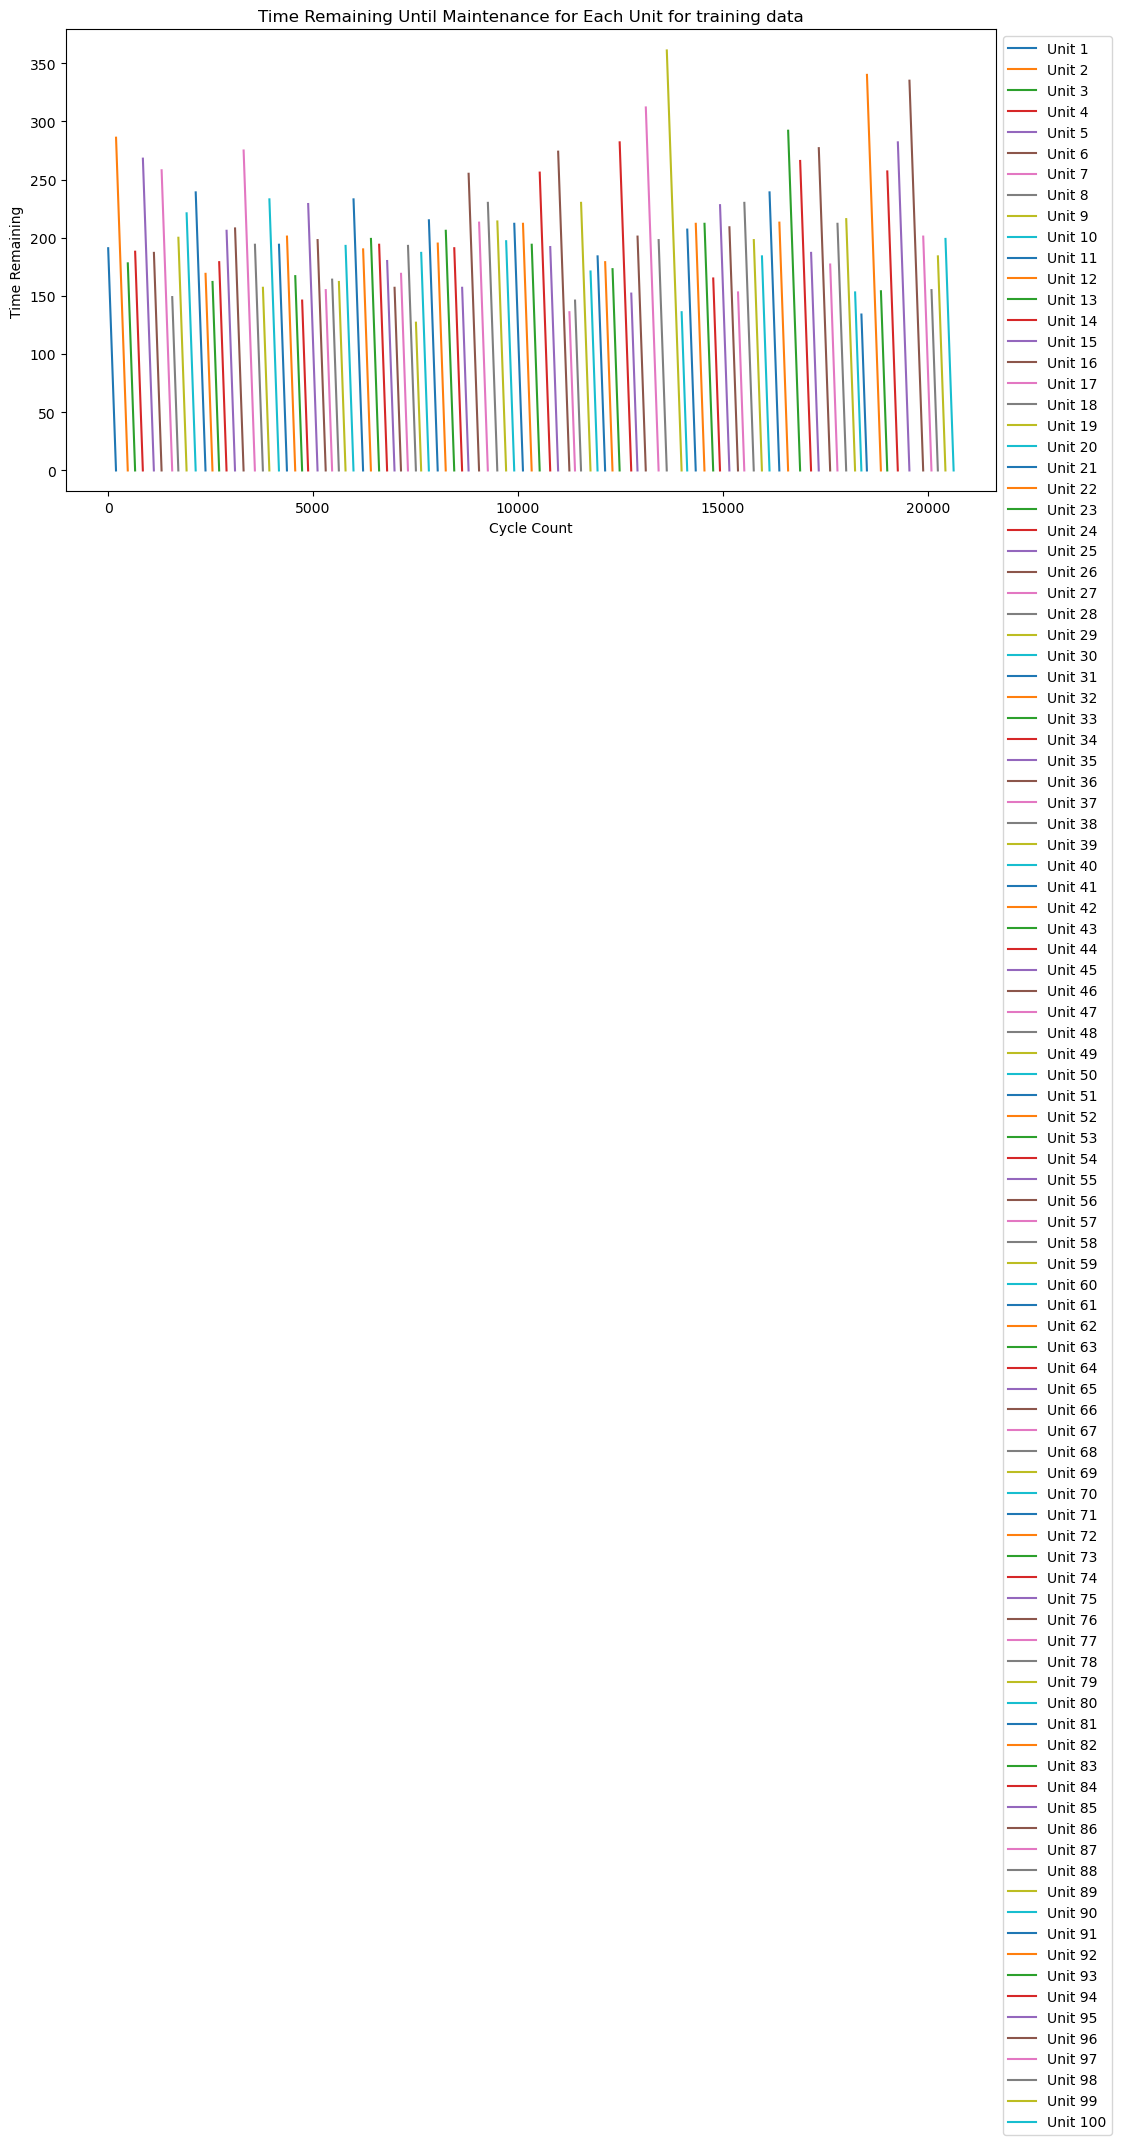

In [221]:
# Plot 'time_remaining for training data'
plt.figure(figsize=(12, 6))
for unit in train_data['unit_number'].unique():
    unit_data = train_data[train_data['unit_number'] == unit]
    plt.plot(unit_data['time_remaining'], label=f'Unit {unit}')
plt.title('Time Remaining Until Maintenance for Each Unit for training data')
plt.xlabel('Cycle Count')
plt.ylabel('Time Remaining')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/timebased_features_units_unitl_maintenance.png')
plt.show()

In [177]:
# Time-based features since the engine starts and the remaining time since the last maintenance for test data
test_data['time_since_start'] = test_data.groupby('unit_number').cumcount()
test_data['time_remaining'] = test_data.groupby('unit_number')['time_since_start'].transform('max') - test_data['time_since_start']

print("Time since the engine started (testing data): \n " , test_data['time_since_start'].head(20))
print("\n\n")
print("Time remaining since the last maintenance (testing data): \n " , test_data['time_remaining'].head(20))

Time since the engine started (testing data): 
  0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
Name: time_since_start, dtype: int64



Time remaining since the last maintenance (testing data): 
  0     30
1     29
2     28
3     27
4     26
5     25
6     24
7     23
8     22
9     21
10    20
11    19
12    18
13    17
14    16
15    15
16    14
17    13
18    12
19    11
Name: time_remaining, dtype: int64


<h2>Model Evaluation and Visualization</h2>

<h4>Model Evaluation Test Set</h4>

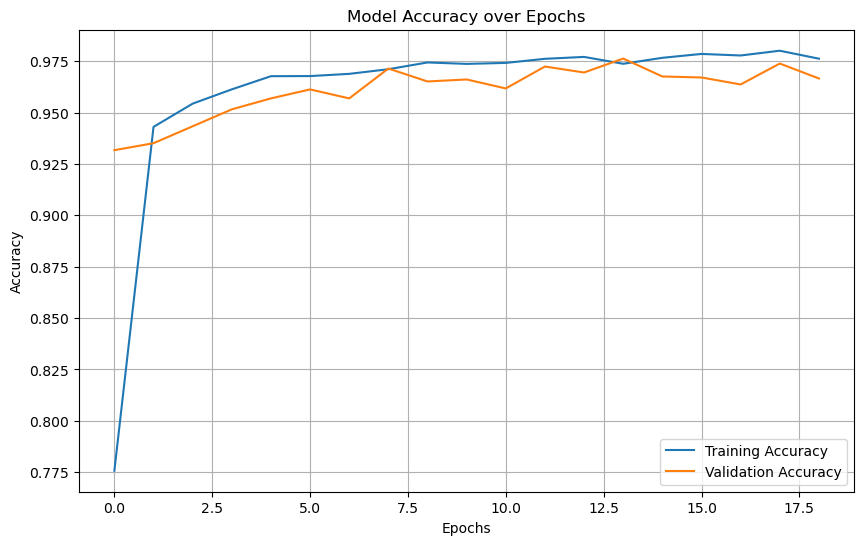

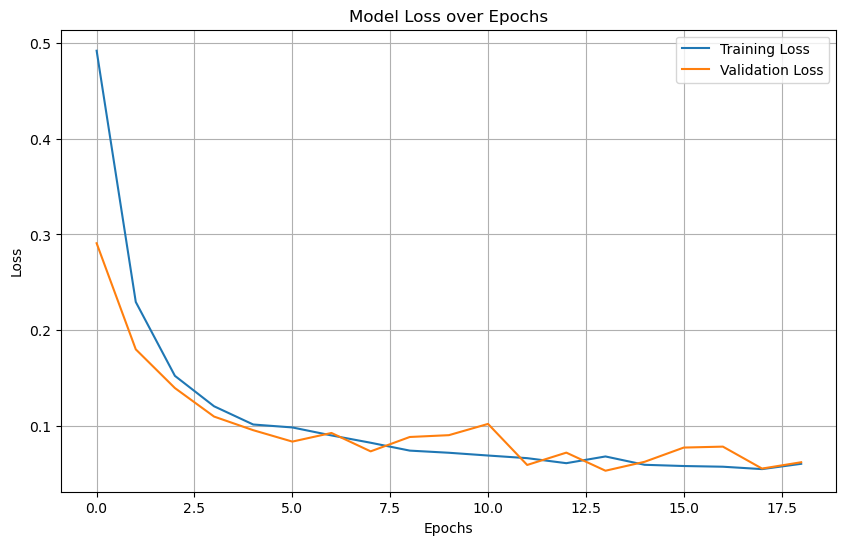

In [179]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Function to plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/accuracy_plot.png')
    plt.show()

# Function to plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/loss_plot.png')
    plt.show()

# Plot accuracy and loss
plot_accuracy(lstm)
plot_loss(lstm)

<h3>Performance Metrics- Precision, Recall, Accuracy, Confusion Matrix for LSTM Model</h3>

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score


X_train, X_test, y_train, y_test = train_test_split(sequence_array, label_array, test_size=0.2, random_state=42)

# Check the shapes to ensure everything is correct
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'\nAccuracy on test data: {scores[1]*100:.2f}%')

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Create a DataFrame to save predictions and actual values to a CSV file
test_set = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
test_set.to_csv('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/predictions.csv', index=False)

# Compute and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix of LSTM Model:\n', cm)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'\nPrecision of LSTM Model: {precision}\n')
print(f'Recall of LSTM Model: {recall}')

X_train shape: (16504, 50, 24)
X_test shape: (4127, 50, 24)
y_train shape: (16504, 1)
y_test shape: (4127, 1)

Accuracy on test data: 98.16%
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Confusion matrix of LSTM Model:
 [[2549   29]
 [  47 1502]]

Precision of LSTM Model: 0.9810581319399085

Recall of LSTM Model: 0.9696578437701743


<h3>Performance metrics- Precision, Recall, Accuracy, Confusion Matrix for GRU Model </h3>

In [51]:
X_train, X_test, y_train, y_test = train_test_split(sequence_array, label_array, test_size=0.2, random_state=42)

# Check the shapes to ensure everything is correct
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'\nAccuracy on test data: {scores[1]*100:.2f}%')

# Make predictions on the test set
y_pred_prob = grumodel.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Create a DataFrame to save predictions and actual values to a CSV file
test_set = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
test_set.to_csv('C:/Users/gouta/OneDrive - andrew.cmu.edu/Documents/CMU_Fall_2024/95820_ANLM/Assignment-1/predictions_gru.csv', index=False)

# Compute and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix of GRU Model:\n', cm)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'\nPrecision of GRU Model: {precision}\n')
print(f'Recall of GRU Model: {recall}')

X_train shape: (16504, 50, 24)
X_test shape: (4127, 50, 24)
y_train shape: (16504, 1)
y_test shape: (4127, 1)

Accuracy on test data: 98.18%
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step

Confusion matrix of GRU Model:
 [[2560   18]
 [  36 1513]]

Precision of GRU Model: 0.9882429784454605

Recall of GRU Model: 0.9767591994835377


**Summary of Comparison:**

* Accuracy: Both models have very similar accuracy, with the GRU model slightly outperforming the LSTM model by 0.02%.
  
* Precision: The GRU model performs better in terms of precision (98.82% vs. 98.11%), meaning it is less likely to incorrectly classify a negative case as positive.
  
* Recall: The GRU model also has a better recall (97.68% vs. 96.97%), meaning it is more capable of identifying true positive cases compared to the LSTM model.

  
**Conclusion:**

* GRU slightly outperforms LSTM in terms of accuracy, precision, and recall, making it the better model for this specific task. The GRU's higher precision and recall indicate that it is more reliable in predicting positive cases correctly and has fewer false negatives and false positives compared to the LSTM model.ision.


<h3>LSTM Model Evaluation on Validation set</h3>

In [188]:
# Path to the saved model
model_path = 'best_model.keras'

# Filter engines with at least 'sequence_length' timesteps
valid_ids = test_df.groupby('unit_number').size() >= sequence_length

# Select the last sequence for valid engines
seq_array_test_last = []
label_array_test_last = []

for id in test_df['unit_number'].unique():
    if valid_ids[id]:  # Only consider valid engines
        id_df = test_df[test_df['unit_number'] == id]
        last_sequence = id_df[sequence_columns].values[-sequence_length:]
        
        # Pad the sequence if it's shorter than sequence_length
        if len(last_sequence) < sequence_length:
            padding = np.zeros((sequence_length - len(last_sequence), last_sequence.shape[1]))
            last_sequence = np.vstack((padding, last_sequence))
        
        seq_array_test_last.append(last_sequence)
        # Pick the last label for the sequence
        last_label = id_df['label1'].values[-1]
        label_array_test_last.append(last_label)

# Convert to numpy arrays
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
label_array_test_last = np.asarray(label_array_test_last).reshape(-1, 1).astype(np.float32)

# Check shapes
print(f'Sequence array test last shape: {seq_array_test_last.shape}')
print(f'Label array test last shape: {label_array_test_last.shape}')

Sequence array test last shape: (93, 50, 24)
Label array test last shape: (93, 1)


In [190]:
import os
from tensorflow.keras.models import load_model


# TODO: Pick the labels for the selected sequences (for the corresponding units)
y_mask = test_df.groupby('unit_number').size() >= sequence_length
label_array_test_last = test_df.groupby('unit_number')['label1'].last().values[y_mask]  # Pick last label for each unit

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)
print(f'Label array test last shape: {label_array_test_last.shape}')


if os.path.isfile(model_path):
    estimator = load_model(model_path)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

# TODO: Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
print(f'Accuracy: {scores_test[1]*100:.2f}%')

Label array test last shape: (93, 1)
Accuracy: 94.62%


In [61]:
# TODO: Make predictions and compute confusion matrix
y_pred_test_prob = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)  # Convert probabilities to class labels
y_true_test = label_array_test_last

# TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
test_set = pd.DataFrame({'Actual': y_true_test.flatten(), 'Predicted': y_pred_test.flatten()})
test_set.to_csv('validation_predictions_lstm.csv', index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


In [63]:
# TODO: Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
print(cm)

# TODO: Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = f1_score(y_true_test, y_pred_test)
print(f'Precision: {precision_test}\nRecall: {recall_test}\nF1-score: {f1_test}')

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[66  2]
 [ 3 22]]
Precision: 0.9166666666666666
Recall: 0.88
F1-score: 0.8979591836734694


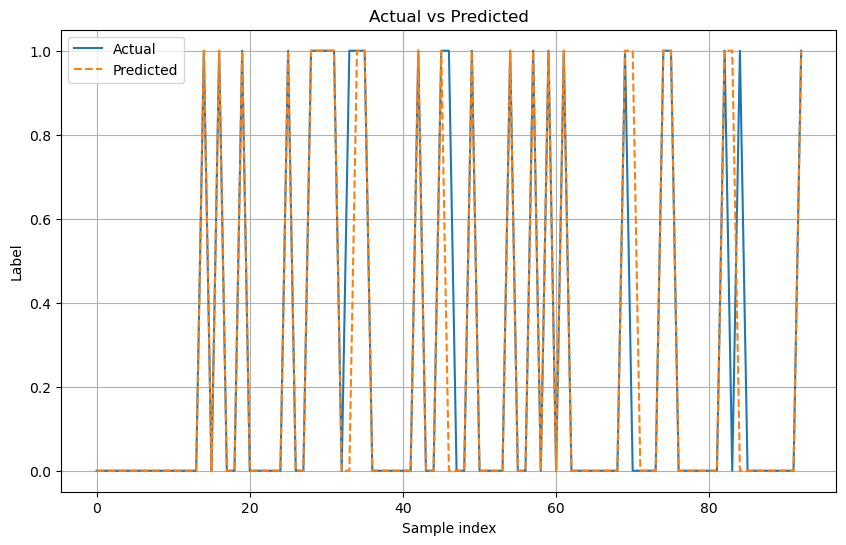

In [65]:
# TODO: Plot predicted and actual data for visual verification

plt.figure(figsize=(10, 6))
plt.plot(y_true_test, label='Actual')
plt.plot(y_pred_test, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample index')
plt.ylabel('Label')
plt.legend()
plt.grid(True)
plt.show()

<h3>GRU Model Evaluation on Validation set</h3>

In [227]:
# Path to the saved model
model_path = 'best_gru_model.keras'

# Filter engines with at least 'sequence_length' timesteps
valid_ids = test_df.groupby('unit_number').size() >= sequence_length

# Select the last sequence for valid engines
seq_array_test_last = []
label_array_test_last = []

for id in test_df['unit_number'].unique():
    if valid_ids[id]:  # Only consider valid engines
        id_df = test_df[test_df['unit_number'] == id]
        last_sequence = id_df[sequence_columns].values[-sequence_length:]
        
        # Pad the sequence if it's shorter than sequence_length
        if len(last_sequence) < sequence_length:
            padding = np.zeros((sequence_length - len(last_sequence), last_sequence.shape[1]))
            last_sequence = np.vstack((padding, last_sequence))
        
        seq_array_test_last.append(last_sequence)
        # Pick the last label for the sequence
        last_label = id_df['label1'].values[-1]
        label_array_test_last.append(last_label)

# Convert to numpy arrays
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
label_array_test_last = np.asarray(label_array_test_last).reshape(-1, 1).astype(np.float32)

# Check shapes
# print(f'Sequence array test last shape: {seq_array_test_last.shape}')
# print(f'Label array test last shape: {label_array_test_last.shape}')

In [69]:
import os

# TODO: Pick the labels for the selected sequences (for the corresponding units)
y_mask = test_df.groupby('unit_number').size() >= sequence_length
label_array_test_last = test_df.groupby('unit_number')['label1'].last().values[y_mask]  # Pick last label for each unit

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)
print(f'Label array test last shape: {label_array_test_last.shape}')

if os.path.isfile(model_path):
    estimator = load_model(model_path)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

# TODO: Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
print(f'Accuracy: {scores_test[1]*100:.2f}%')

Label array test last shape: (93, 1)
Accuracy: 96.77%


In [192]:
# TODO: Make predictions and compute confusion matrix
y_pred_test_prob = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)  # Convert probabilities to class labels
y_true_test = label_array_test_last

# TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
test_set = pd.DataFrame({'Actual': y_true_test.flatten(), 'Predicted': y_pred_test.flatten()})
test_set.to_csv('validation_predictions_gru.csv', index=False)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step


In [194]:
# TODO: Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
print(cm)

# TODO: Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = f1_score(y_true_test, y_pred_test)
print(f'Precision: {precision_test}\nRecall: {recall_test}\nF1-score: {f1_test}')

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[68  0]
 [ 5 20]]
Precision: 1.0
Recall: 0.8
F1-score: 0.888888888888889


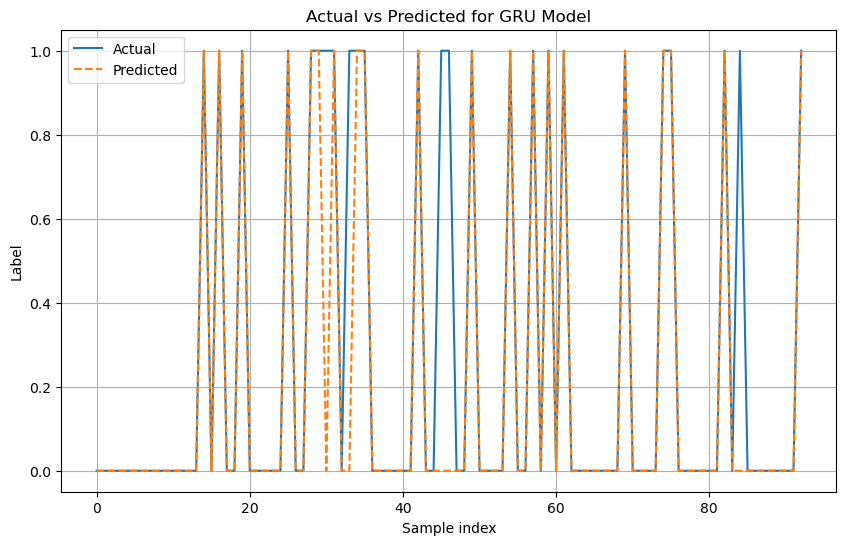

In [196]:
# TODO: Plot predicted and actual data for visual verification

plt.figure(figsize=(10, 6))
plt.plot(y_true_test, label='Actual')
plt.plot(y_pred_test, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted for GRU Model')
plt.xlabel('Sample index')
plt.ylabel('Label')
plt.legend()
plt.grid(True)
plt.show()

<h3> Visualization</h3>

In [198]:
# Load the LSTM model
lstm_model_path = 'best_model.keras'
estimator_lstm = load_model(lstm_model_path)

# Load the GRU model
gru_model_path = 'best_gru_model.keras'
estimator_gru = load_model(gru_model_path)

# Now you can make predictions with both models
y_pred_lstm = estimator_lstm.predict(seq_array_test_last)
y_pred_gru = estimator_gru.predict(seq_array_test_last)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


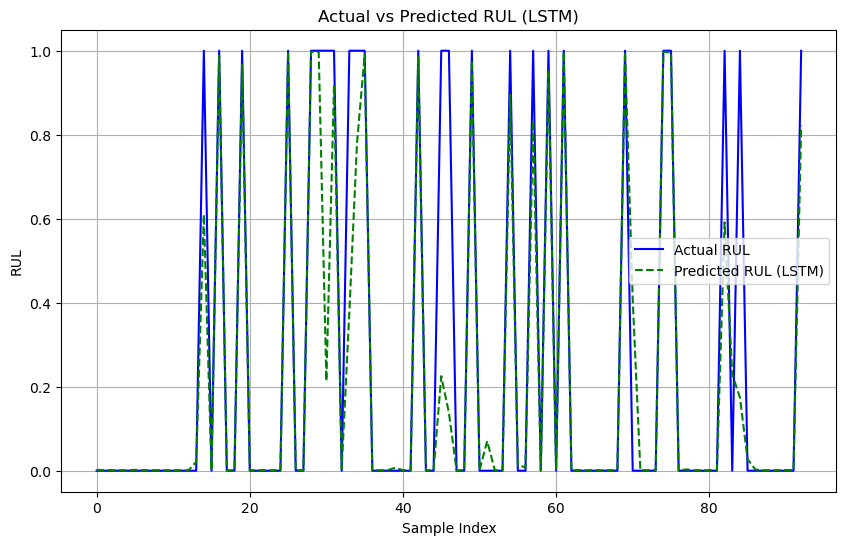

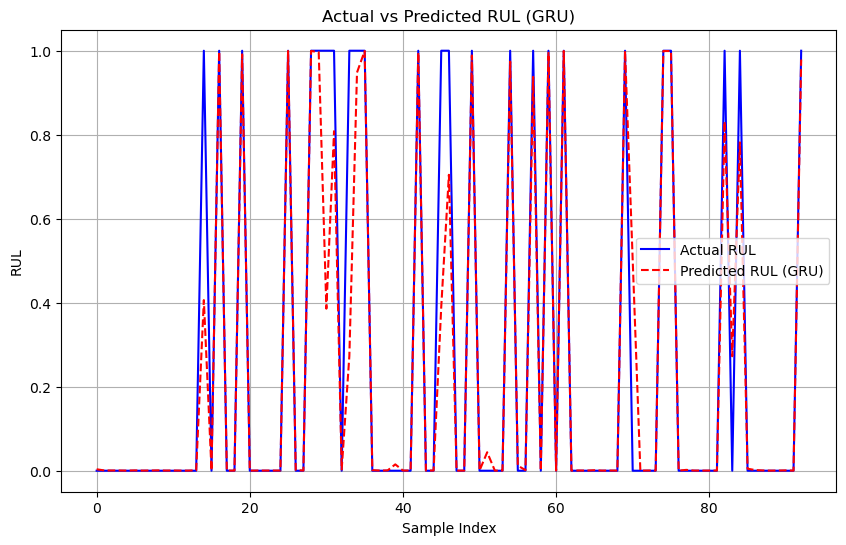

In [200]:
# Plot LSTM
plt.figure(figsize=(10, 6))
plt.plot(label_array_test_last, label='Actual RUL', color='blue')
plt.plot(y_pred_lstm, label='Predicted RUL (LSTM)', linestyle='--', color='green')
plt.title('Actual vs Predicted RUL (LSTM)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

# Plot GRU
plt.figure(figsize=(10, 6))
plt.plot(label_array_test_last, label='Actual RUL', color='blue')
plt.plot(y_pred_gru, label='Predicted RUL (GRU)', linestyle='--', color='red')
plt.title('Actual vs Predicted RUL (GRU)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

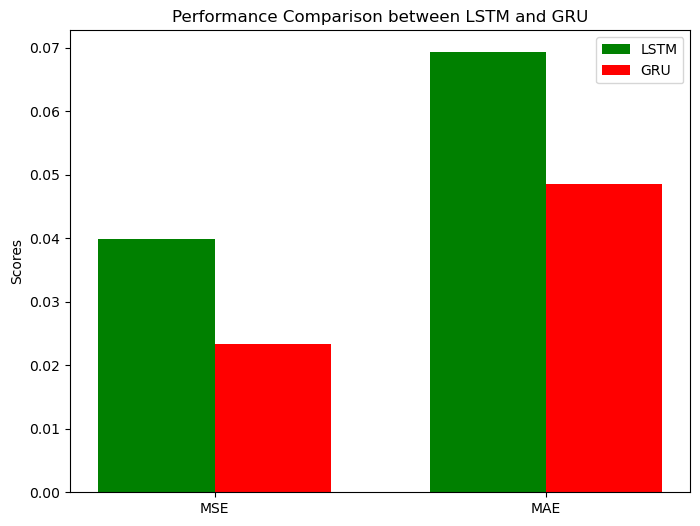

In [202]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_lstm = mean_squared_error(label_array_test_last, y_pred_lstm)
mae_lstm = mean_absolute_error(label_array_test_last, y_pred_lstm)

mse_gru = mean_squared_error(label_array_test_last, y_pred_gru)
mae_gru = mean_absolute_error(label_array_test_last, y_pred_gru)

# Plot comparison
metrics = ['MSE', 'MAE']
lstm_metrics = [mse_lstm, mae_lstm]
gru_metrics = [mse_gru, mae_gru]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM', color='green')
rects2 = ax.bar(x + width/2, gru_metrics, width, label='GRU', color='red')

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison between LSTM and GRU')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


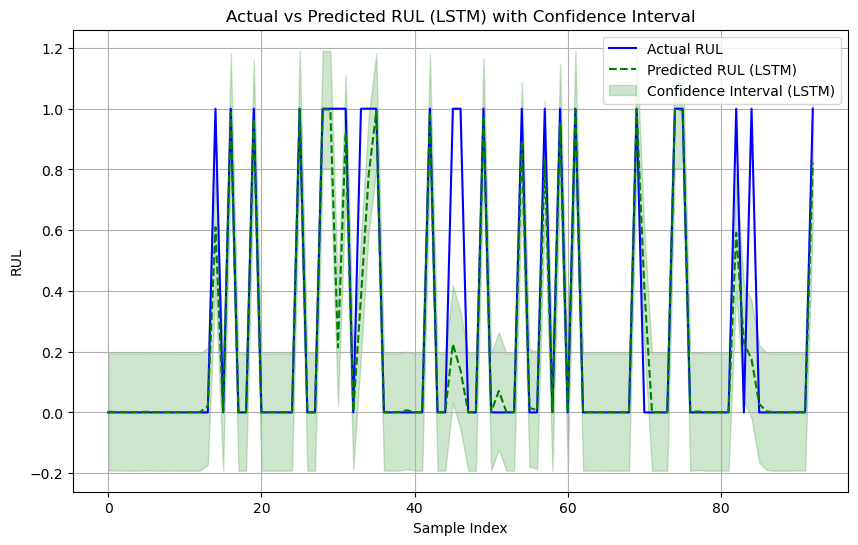

In [204]:
# Calculate residuals
residuals_lstm = label_array_test_last - y_pred_lstm
residuals_gru = label_array_test_last - y_pred_gru

# Standard deviation of the residuals
std_residuals_lstm = np.std(residuals_lstm)
std_residuals_gru = np.std(residuals_gru)

# Plot with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(label_array_test_last, label='Actual RUL', color='blue')
plt.plot(y_pred_lstm, label='Predicted RUL (LSTM)', linestyle='--', color='green')
plt.fill_between(np.arange(len(y_pred_lstm)), y_pred_lstm[:, 0] - std_residuals_lstm, y_pred_lstm[:, 0] + std_residuals_lstm, color='green', alpha=0.2, label='Confidence Interval (LSTM)')
plt.title('Actual vs Predicted RUL (LSTM) with Confidence Interval')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()


<h3>Summary</h3>

**RUL Prediction:**

* Both models perform well in predicting the Remaining Useful Life (RUL), but the GRU model tracks the actual RUL more closely, particularly in regions where the LSTM underperforms (sample indices 20-40 and 60-80).

* MSE Comparison:

The GRU model's MSE is significantly lower (≈ 0.024) compared to the LSTM model's MSE (≈ 0.042). This shows that the GRU model is more accurate in minimizing large errors in predictions.

* MAE Comparison:

The GRU model's MAE is also lower (≈ 0.045) compared to the LSTM model's MAE (≈ 0.07), further demonstrating the superior predictive performance of GRU by reducing the average prediction error.

* Conclusion:

GRU outperforms LSTM: Based on both visual comparison and quantitative metrics (MSE and MAE), the GRU model demonstrates superior performance in predicting RUL. It has lower prediction errors across both metrics, indicating that it provides more accurate and reliable predictions.

**Advantages and Disadvantages of LSTM and GRU in Predictive Maintenance:**

**LSTM Advantages:**

* Handling Long-Term Dependencies: LSTM's ability to store information for long sequences helps it capture long-term dependencies in time-series data. This is especially beneficial in predictive maintenance where long periods of historical data can influence future failures.

* Lower Risk of Vanishing Gradient: LSTMs are better at retaining information from earlier time steps and handling the vanishing gradient problem that standard RNNs face.

* Higher Recall: The higher recall for LSTM shows it is better at detecting true positives (failures), which is critical for reducing unexpected equipment breakdowns.


**LSTM Disadvantages:**

* Higher Computational Cost: LSTMs are computationally heavier than GRU due to their more complex architecture. This could result in slower training and inference times, especially for large datasets.

* Overfitting Risk: Due to their complexity, LSTMs may be more prone to overfitting when there is limited data.


**GRU Advantages:**

* Simpler Architecture: GRUs are simpler and have fewer gates compared to LSTMs, making them faster to train and more computationally efficient. This efficiency is useful in real-time predictive maintenance systems that require quick processing.

* Higher Precision: GRUs demonstrated higher precision, meaning they are better at reducing false alarms (false positives), which is beneficial in systems where false alarms are costly and can lead to unnecessary maintenance actions.


**GRU Disadvantages:**

* Less Effective with Long-Term Dependencies: GRUs might struggle with very long sequences where earlier time steps contain crucial information, as they may not retain as much long-term information as LSTMs.

* Lower Recall: GRUs had lower recall, meaning they missed more failures, which could be risky in high-stakes applications where every failure must be predicted.

**Computational Efficiency:**

* Training Time: GRUs are typically faster to train due to their simpler architecture. This is an advantage in scenarios where computational resources are limited or when the model needs to be frequently retrained.

* Inference Time: In real-time predictive maintenance systems, GRUs may be preferable due to their faster inference time, making them more suitable for online or edge deployments.

**Future Directions:**

* Use of Bi-directional LSTMs:

Bi-directional LSTMs process input sequences in both forward and backward directions, allowing them to capture more context from both past and future time steps. This could improve model performance by leveraging both past and future information to predict RUL more accurately.


* Ensemble Models:

Ensemble learning involves combining multiple models like LSTM, GRU, and possibly other models like CNNs to improve predictive performance. By averaging or voting on predictions from multiple models, ensemble methods can reduce variance and improve generalization.
Stacking: A form of ensemble learning where different models are trained, and their predictions are used as input to a higher-level model, could further improve prediction accuracy and robustness.


* Incorporating Attention Mechanisms:

Attention mechanisms allow the model to focus on the most important parts of the input sequence. This could help the model weigh certain time steps more heavily when predicting RUL, improving interpretability and performance, especially in complex time-series datasets.